# 3. Model tests
## 3.03 Example: Support Vector Regression Model

In [1]:
import sys
sys.path.append("../../")
print(sys.executable)

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/bin/python3


In [2]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dask
dask.config.set(scheduler='threads')
import xarray as xr
sys.path.append("../../")
from python.aux.utils_floodmodel import reshape_multiday_predictand
from python.aux.utils_floodmodel import add_future_vars
from python.aux.verification import verify, ME, RMSE, RMSE_persistence, NSE, NSE_diff

## Loading the data
Sample dataset contained in the git repository.

As you are reading these lines, you opened the notebook in the `./docs/` folder of the main repository directory. To access the sample dataset that was delivered to you with the code, step outside the current directory (`../`) and enter the `data/` folder. The names of the sample datasets are `smallsampledata-era5.nc` and `smallsampledata-glofas.nc`, both in netCDF format, a user-friendly format that keeps the file size low and stores meta-data within the file.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data.

The features are already prepared and ready to use, hence why they can be loaded directly from the `features_xy.nc` file.

Let's open the files and see what's in there:

In [3]:
# load data
version = 'v1'

if version == 'v1':
    features = xr.open_dataset('../../data/features_xy.nc')
    y = features['dis']
    X = features.drop(['dis'])
elif version == 'v2':
    features = xr.open_dataset('../../data/features_xy_v2.nc')
    y = features['dis']
    X = features.drop(['dis', 'dis_diff'])

In [4]:
features

<xarray.Dataset>
Dimensions:     (time: 5478)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
    latitude    float64 ...
    longitude   float64 ...
Data variables:
    cp          (time) float64 ...
    lsp         (time) float64 ...
    swvl1       (time) float64 ...
    ro          (time) float64 ...
    sd          (time) float64 ...
    lsp-1       (time) float64 ...
    lsp-2       (time) float64 ...
    lsp-3       (time) float64 ...
    lsp-4-10    (time) float64 ...
    lsp-11-24   (time) float64 ...
    lsp-25-54   (time) float64 ...
    lsp-55-180  (time) float64 ...
    cp-1        (time) float64 ...
    cp-2        (time) float64 ...
    cp-3        (time) float64 ...
    sd_diff     (time) float64 ...
    dis         (time) float64 ...

Some control parameters for the procedure:

 * `add_shift_switch`: Shift and add shifted values as new features for multi-day forecasts. (only needed if forecasting multiple days at once => currently only implemented with nns!)
 * `dis_shift_1`: Add the discharge from the last day as additional feature for testing purposes.
 * `abs_vals_switch`: Model is trained on absolute discharge values if True and on differences/change in discharge else.

In [5]:
dis_shift_switch = False

In [6]:
abs_vals_switch = False

Begin with some short preprocessing..

In [7]:
if dis_shift_switch:
    dis_shift_1 = y.shift(time=1)
    X = X.assign({'dis-1': dis_shift_1})

In [8]:
X_base = X.to_array(dim='features').T
y_base = y

Next, we split the dataset into three parts for 
- training (the longest period for estimating the free parameters within the model), 
- validation (for tuning hyperparameters) and 
- testing (for the model comparison).

In [9]:
period_train = dict(time=slice(None, '1990'))
period_valid = dict(time=slice('1991', '1993'))
period_test = dict(time=slice('1994', '1995'))

In [10]:
X_train, y_train = X_base.loc[period_train], y_base.loc[period_train]
X_valid, y_valid = X_base.loc[period_valid], y_base.loc[period_valid]
X_test, y_test = X_base.loc[period_test], y_base.loc[period_test]

In [11]:
def remove_outlier(x):
    """Removes outliers under, over 1th, 99th percentile of the input pandas series."""
    x99 = x.quantile(0.99)
    x01 = x.quantile(0.01)
    x = x.where(x > x01).dropna()
    x = x.where(x < x99).dropna()
    return x

In [12]:
X_train.shape, y_train.shape

((3652, 16), (3652,))

In [13]:
time = y_train.time
Xda = X_train.chunk(dict(time=-1, features=-1)).dropna(dim='time').to_pandas()

if abs_vals_switch:
    # train on absolute values
    yda = y_train.to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]
else:
    # train on change in discharge values
    yda = y_train.diff(dim='time').to_pandas().loc[Xda.index]
    # removing outlier and removing same parts from X
    yda = remove_outlier(yda)
    Xda = Xda.loc[yda.index]

In [14]:
import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA


from sklearn.svm import SVR

# Define SupportVectorRegression Model

In [15]:
model = SVR(kernel='poly',
            C=10,
            epsilon=0.01,
            degree=1,
           )

pipe = Pipeline([('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', model),], verbose=True)

pipe.fit(Xda, yda)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.8s


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 SVR(C=10, cache_size=200, coef0=0.0, degree=1, epsilon=0.01,
                     gamma='auto_deprecated', kernel='poly', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=True)

### in sample test for the predicted change, to verify functionality

In [16]:
def add_time(vector, time, name=None):
    """Converts arrays to xarrays with a time coordinate."""
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

[-35392.9916366  -34393.32183156 -31187.23058533 ... -18710.13052999
 -12520.77361056 -20557.7137862 ]


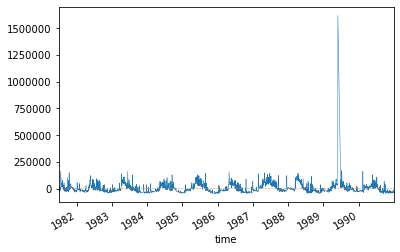

In [17]:
insample_check = pipe.predict(Xda)
print(insample_check)
insample_check = add_time(insample_check, Xda.index, name='forecast')
insample_check.where(insample_check > insample_check.quantile(0.01)).to_pandas().plot(linewidth=0.5)
yda.plot(linestyle='--', linewidth=0.5)

#### Note that the insample test shows, that the forecasted discharge change is about one order of magnitude over the real one, indicating .

Set the frequency at which forecast are started.

In [18]:
# prediction start from every nth day
# if in doubt, leave n = 1 !!!
n = 1
X_pred = X_valid[::n]
y_pred = pipe.predict(X_pred.values)
y_pred = add_time(y_pred, X_pred.time, name='forecast')

In [19]:
def plot_pred_series(x, y, y_truth, forecast_range=14):
    """Convenience function for converting the prediction output in xr.DataArray with the sa"""
    # assuming x has a resolution of 1 day, else a key error will result.
    dt = x.time[1]-x.time[0]
    # create prediction series containing nans
    pred = x.copy().isel(features=0)*np.nan
    # rename and drop unnecessary stuff
    pred.name = 'prediction'
    pred = pred.drop('features')
    # add truth at time t=t0 for each forecast
    y_steps = y[1::forecast_range].copy()
#    print(pred)
    pred.loc[y_steps.time-dt] = y_truth.loc[y_steps.time-dt]
    pred.loc[y_steps.time] = y_steps + pred.loc[y_steps.time-dt].values
    
    # add multiple forecast days onto prediction
    yinit = x.time.dt.year[0].values
    tinit = f"{yinit}-01-01"
    yend = x.time.dt.year[-1].values
    tend = f"{yend}-12-31"
    time_vec = y_steps.time.copy()
    for i in range(1, forecast_range-2):
        tind = (y_steps.time+dt*i).sel(time=slice(tinit, tend))
        try: # easy way to ignore indexing out of the date range, happens only at the jump upwards of the boundary
            pred.loc[tind] = y.loc[tind] + pred.loc[tind-dt].values
        except:
            pred.loc[tind[:-1]] = y.loc[tind[:-1]] + pred.loc[tind[:-1]-dt].values
    
    fig, ax = plt.subplots(figsize=(15,5))
    y_truth.sel({'time': x.time}).to_pandas().plot(ax=ax, label='truth')
    pred.to_pandas().plot(ax=ax, label='forecast')
    plt.legend()
    ax.set_ylabel('river discharge [m$^3$/s]')
    return pred

<xarray.DataArray 'dis' (time: 1096)>
array([ 602.04248 ,  609.904907,  632.579773, ..., 1132.167725, 1123.2948  ,
       1120.796753])
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1993-12-31
    latitude   float64 ...
    longitude  float64 ...
Attributes:
    long_name:  discharge
    units:      m3/s


Text(0.5, 1.0, 'Support Vector Regression: |\xa0RMSE=212.41; NSE=0.85')

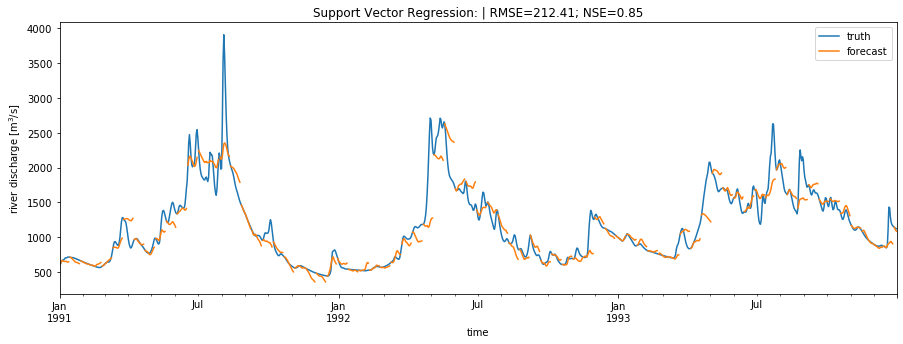

In [20]:
pred = plot_pred_series(X_pred, y_pred, y, forecast_range=14)

# calculate RMSE and NSE and put it in the plot title
# differences
#y_o = y_valid.diff(dim='time')
#y_m = y_pred.where(y_o, drop=True)
# absolute values
y_o = y_valid
y_m = pred
print(y_o)
rmse = np.sqrt(np.nanmean((y_m - y_o)**2))
nse = 1 - np.sum((y_m - y_o)**2)/(np.sum((y_o - np.nanmean(y_o))**2))

plt.title(f"Support Vector Regression: | RMSE={round(float(rmse), 2)}; NSE={round(float(nse), 2)}")

#### Check the skill of a 14-day persistence forecast:

In [21]:
forecast_range = 14
y_o_pers = y_valid
# persistence
y_m_pers = y_valid.copy()
for i in range(1, forecast_range):
    y_m_pers.loc[y_valid.time[i::forecast_range]] = y_valid.shift(time=i)[i::forecast_range].values
    
rmse = np.sqrt(np.nanmean((y_m_pers - y_o_pers)**2))
nse = 1 - np.sum((y_m_pers - y_o_pers)**2)/(np.sum((y_o_pers - np.nanmean(y_o_pers))**2))
print(f"Persistence {forecast_range}-day forecast: RMSE={round(float(rmse), 2)}; NSE={round(float(nse.values), 2)}")

Persistence 14-day forecast: RMSE=251.09; NSE=0.77


Now, lets run a few different settings and compare the results:

|   kernel    |   C   |  epsilon   |   degree    |   RMSE   |   NSE   | 
| :--------: | :-----: | :-----: | :-----: | :-----: |:-----: |
| rbf | 1 | 0.01 | 1 | 225.41  |   0.83
| rbf | 1 | 0.1 | 1 | 225.36  |   0.83
| rbf | 1 | 1 | 1 | 225.53   |  0.83
| rbf | 10 | 0.01 | 1 | 207.92  |   0.86
| rbf | 10 | 0.1 | 1 | 207.92  |   0.86
| rbf | 10 | 1 | 1 | 208.02  |   0.86
| rbf | 100 | 0.01 | 1 | 191.2  |   0.88
| rbf | 100 | 0.1 | 1 | 191.26   |  0.88
| rbf | 100 | 1 | 1 | 191.33   |  0.88
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| poly | 1 | 0.01 | 1 | 215.74  |   0.84
| poly | 1 | 0.01 | 2 | 215.6   |  0.85
| poly | 1 | 0.01 | 3 | 214.36  |   0.85
| poly | 1 | 0.01 | 4 | 400.42  |   0.47
| poly | 1 | 0.01 | 5 | 857.25  |   -1.45
| poly | 1 | 0.1 | 1 | 215.68   |  0.85
| poly | 1 | 0.1 | 2 | 215.57   |  0.85
| poly | 1 | 0.1 | 3 | 214.44   |  0.85
| poly | 1 | 0.1 | 4 | 400.21  |   0.47
| poly | 1 | 0.1 | 5 | 856.67  |   -1.44
| poly | 1 | 1 | 1 | 215.8  |   0.84
| poly | 1 | 1 | 2 | 215.48   |  0.85
| poly | 1 | 1 | 3 | 215.53   |  0.85
| poly | 1 | 1 | 4 | 400.71   |  0.47
| poly | 1 | 1 | 5 | 849.48   |  -1.4
| poly | 10 | 0.01 | 1 | 212.41   |  0.85
| poly | 10 | 0.01 | 2 | 210.54   |  0.85
| poly | 10 | 0.01 | 3 | 237.14  |   0.81
| poly | 10 | 0.01 | 4 | 629.68  |   -0.32
| poly | 10 | 0.01 | 5 | 930.53  |   -1.88
| poly | 10 | 0.1 | 1 | 212.44  |   0.85
| poly | 10 | 0.1 | 2 | 210.64  |   0.85
| poly | 10 | 0.1 | 3 | 237.7  |   0.81
| poly | 10 | 0.1 | 4 | 628.9  |   -0.32
| poly | 10 | 0.1 | 5 | 928.97   |  -1.88
| poly | 10 | 1 | 1 | 212.03   |  0.85
| poly | 10 | 1 | 2 | 209.92   |  0.85
| poly | 10 | 1 | 3 | 238.99   |  0.81
| poly | 10 | 1 | 4 | 638.4   |  -0.36
| poly | 10 | 1 | 5 | 925.24   |  -1.85
| poly | 100 | 0.01 | 1 | 211.66  |   0.85
| poly | 100 | 0.01 | 2 | 212.83   |  0.85
| poly | 100 | 0.01 | 3 | 275.11  |   0.75
| poly | 100 | 0.01 | 4 | 720.05   |  -0.73
| poly | 100 | 0.01 | 5 | 665.52   |  -0.48
| poly | 100 | 0.1 | 1 | 211.7  |   0.85
| poly | 100 | 0.1 | 2 | 212.93   |  0.85
| poly | 100 | 0.1 | 3 | 274.38   |  0.75
| poly | 100 | 0.1 | 4 | 720.36   |  -0.73
| poly | 100 | 0.1 | 5 | 669.57   |  -0.49
| poly | 100 | 1 | 1 | 211.71   |  0.85
| poly | 100 | 1 | 2 | 212.31   |  0.85
| poly | 100 | 1 | 3 | 267.6   |  0.76
| poly | 100 | 1 | 4 | 724.14   |  -0.75
| poly | 100 | 1 | 5 | 660.95   |  -0.46
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| persistence 14-day forecast  | |  | | 251.09 | 0.77 |


Concluding, a polynomial degree of 2 works best for the 'poly' kernel. It seems that the value of `epsilon` does not matter that much and even the impact of varying `C` is rather negligible. For the best setting, with `kernel='rbf'`, `C=100` and `epsilon=0.01`, the metrics `RMSE=191.2` and `NSE=0.88` are comparable to the result of the LinearRegressionModel, but this may be intriguing, as the insample test above shows, that the model exhibits some strange behaviour, which might indicate that SVR is just not a good model for predicting such kind of time series (even if the metrics for the validation period seem ok).